In [1]:
import pandas as pd
import numpy as np
get_ipython().magic(u'matplotlib inline')

In [2]:
data_path="C:\eclipse-jee-luna-SR1-win32\workspace\DateYourData_25022016\original data\\"

In [3]:
train = pd.read_csv(data_path+'TrainD.csv')
test = pd.read_csv(data_path+'TestD.csv')

In [4]:
train['Earliest_Start_Date'] = pd.to_datetime(train['Earliest_Start_Date'],format='%Y-%m-%d')
test['Earliest_Start_Date'] = pd.to_datetime(test['Earliest_Start_Date'],format='%Y-%m-%d')
train['Earliest_Start_Date'] = train['Earliest_Start_Date'].apply(lambda x: x.toordinal())
test['Earliest_Start_Date'] = test['Earliest_Start_Date'].apply(lambda x: x.toordinal())

In [5]:
train.shape, test.shape

((192582, 115), (107428, 114))

In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

import matplotlib.pylab as plt
get_ipython().magic(u'matplotlib inline')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [7]:
target='Is_Shortlisted'
Internship_ID = 'Internship_ID'
Student_ID = 'Student_ID'

In [8]:
train['Is_Shortlisted'].value_counts()

0    168003
1     24579
Name: Is_Shortlisted, dtype: int64

In [9]:
def modelfit(alg, dtrain, dtest, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Is_Shortlisted'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain['Is_Shortlisted'], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Is_Shortlisted'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Is_Shortlisted'], dtrain_predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
                
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.8776
AUC Score (Train): 0.753463
CV Score : Mean - 0.6496207 | Std - 0.04112981 | Min - 0.5756511 | Max - 0.6992646


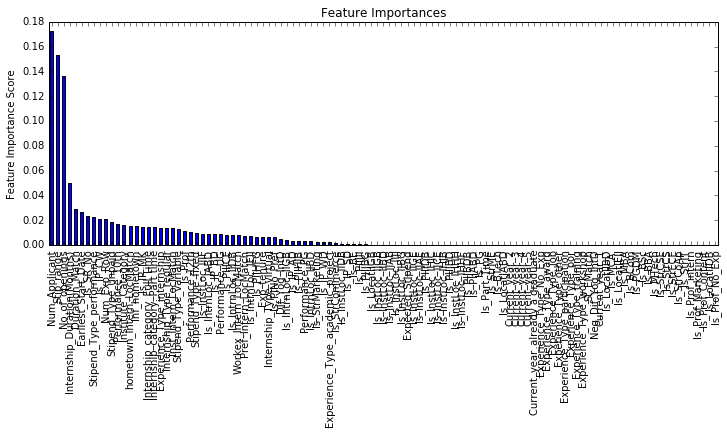

In [10]:
# ### Baseline Model
# Since here the criteria is AUC, simply predicting the most prominent class would give an AUC of 0.5 always. 
# Another way of getting a baseline model is to use the algorithm without tuning, i.e. with default parameters.

#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, Internship_ID,Student_ID,'Preferred_location']]
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, train, test, predictors)

In [11]:
pd.Series(gbm0.feature_importances_, predictors).sort_values(ascending=False)[1:30]

Stip_range                       0.153413
No_of_openings                   0.136186
Internship_Duration(Months)      0.050250
Duration_Match                   0.028908
Earliest_Start_Date              0.026706
Is_SR_No                         0.023380
Stipend_Type_performance         0.022769
Is_IP_CW                         0.021242
Num_Exp_Row                      0.020874
Stipend_Type_unpaid              0.018643
Performance_10th                 0.017136
Institute_Category               0.015884
hometown_Intern_LocMatch         0.015667
Inf_hometown                     0.015537
Is_IP_MK                         0.014804
Internship_category_Full Time    0.014541
Internship_category_Part time    0.014445
Experience_Type_internship       0.013774
Internship_Type_regular          0.013609
Inst_Intern_LocMatch             0.013395
Stipend_Type_variable            0.012768
Is_Prof                          0.011169
Performance_12th                 0.010718
Stipend_Type_fixed               0

In [12]:
predictors1 = ['Stip_range','No_of_openings','Internship_Duration(Months)','Duration_Match','Earliest_Start_Date','Is_SR_No',
               'Stipend_Type_performance','Is_IP_CW','Num_Exp_Row','Stipend_Type_unpaid','Performance_10th','Institute_Category',
               'hometown_Intern_LocMatch','Inf_hometown','Is_IP_MK','Internship_category_Full Time','Internship_category_Part time',
               'Experience_Type_internship','Internship_Type_regular','Inst_Intern_LocMatch','Stipend_Type_variable','Is_Prof',
               'Performance_12th','Stipend_Type_fixed','Is_InstLoc_IIIF','Is_IntrnLoc_JABD','Is_IP_BD','Performance_UG','Is_PlIJCE']

In [13]:
predictors = predictors1
param_test1 = {'n_estimators':list(range(20,81,10))}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,
                                                               min_samples_leaf=50,max_depth=8,max_features='sqrt', subsample=0.8,random_state=10),
                        param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=8, max_features='sqrt', max_leaf_nodes=None,
              min_samples_leaf=50, min_samples_split=500,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'n_estimators': [20, 30, 40, 50, 60, 70, 80]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [14]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_, gsearch1.best_estimator_

([mean: 0.65121, std: 0.01703, params: {'n_estimators': 20},
  mean: 0.65283, std: 0.01781, params: {'n_estimators': 30},
  mean: 0.65010, std: 0.01773, params: {'n_estimators': 40},
  mean: 0.64615, std: 0.01456, params: {'n_estimators': 50},
  mean: 0.64347, std: 0.01475, params: {'n_estimators': 60},
  mean: 0.64144, std: 0.01408, params: {'n_estimators': 70},
  mean: 0.64062, std: 0.01455, params: {'n_estimators': 80}],
 {'n_estimators': 30},
 0.65282691770085655,
 GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
               max_depth=8, max_features='sqrt', max_leaf_nodes=None,
               min_samples_leaf=50, min_samples_split=500,
               min_weight_fraction_leaf=0.0, n_estimators=30,
               presort='auto', random_state=10, subsample=0.8, verbose=0,
               warm_start=False))

In [15]:
predictors = predictors1
param_test2 = {'max_depth':list(range(2,7,2)), 'min_samples_split':list(range(100,400,100))}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=30,
                                                max_features='sqrt', subsample=0.8, random_state=10), 
                       param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features='sqrt', max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=30,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_depth': [2, 4, 6], 'min_samples_split': [100, 200, 300]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [ ]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_,gsearch2.best_estimator_

([mean: 0.64926, std: 0.02347, params: {'max_depth': 2, 'min_samples_split': 100},
  mean: 0.64926, std: 0.02347, params: {'max_depth': 2, 'min_samples_split': 200},
  mean: 0.64926, std: 0.02347, params: {'max_depth': 2, 'min_samples_split': 300},
  mean: 0.66088, std: 0.02053, params: {'max_depth': 4, 'min_samples_split': 100},
  mean: 0.66085, std: 0.02295, params: {'max_depth': 4, 'min_samples_split': 200},
  mean: 0.66020, std: 0.02080, params: {'max_depth': 4, 'min_samples_split': 300},
  mean: 0.65397, std: 0.01762, params: {'max_depth': 6, 'min_samples_split': 100},
  mean: 0.65068, std: 0.01428, params: {'max_depth': 6, 'min_samples_split': 200},
  mean: 0.65494, std: 0.02075, params: {'max_depth': 6, 'min_samples_split': 300}],
 {'max_depth': 4, 'min_samples_split': 100},
 0.66087526297620702,
 GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
               max_depth=4, max_features='sqrt', max_leaf_nodes=None,
               min_samples_leaf=1, min_s

In [ ]:
predictors = predictors1
param_test3 = {'min_samples_split':list(range(50,200,50)), 'min_samples_leaf':list(range(30,71,10))}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=30,max_depth=4,
                                                    max_features='sqrt', subsample=0.8, random_state=10), 
                       param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])


In [ ]:
gsearch3.grid_scores_,gsearch2.best_params_,gsearch3.best_estimator_, gsearch3.best_score_

In [ ]:
modelfit(gsearch3.best_estimator_, train, test, predictors)

In [ ]:
#Tune max_features:

#Grid seach on subsample and max_features
param_test4 = {'max_features':list(range(5,20,2))}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=30,max_depth=4, 
                            min_samples_split=100, min_samples_leaf=70, subsample=0.8, random_state=10),
                       param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])

In [ ]:
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

In [ ]:
### Step3- Tune Subsample and Lower Learning Rate
#Grid seach on subsample and max_features
param_test5 = {'subsample':[0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=30,max_depth=4, 
                            min_samples_split=100, min_samples_leaf=70, random_state=10, max_features=7),
                       param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])

In [ ]:
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

In [ ]:
#  With all tuned lets try reducing the learning rate and proportionally increasing the number of estimators to get
#  more robust results:
#Choose all predictors except target & IDcols
predictors = predictors1
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=120,max_depth=4, min_samples_split=150, 
                                         min_samples_leaf=70, subsample=0.85, random_state=10, max_features=7)
modelfit(gbm_tuned_1, train, test, predictors)

In [ ]:
est = GradientBoostingClassifier(learning_rate=0.05, n_estimators=120,max_depth=4, min_samples_split=100, 
                                         min_samples_leaf=70, subsample=0.85, random_state=10, max_features=7)

In [ ]:
est.fit(train[predictors],train[target])

In [ ]:
# predict probabilities
prob = est.predict_proba(test[predictors])[:,1]

In [ ]:
test1=test
test1['Is_Shortlisted']=prob[:]
test1.to_csv(data_path+'DYD_SEC1.csv',columns=['Internship_ID','Student_ID','Is_Shortlisted'],index=False)